In [143]:
from importlib import reload
from typing import List

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from serial import Serial

import spectrum_painting_data as sp_data
import spectrum_painting_model as sp_model
import spectrum_painting_plotting as sp_plot
import spectrum_painting_predict as sp_predict
import spectrum_painting_training as sp_training

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Number of training images: 333
Number of testing images: 143


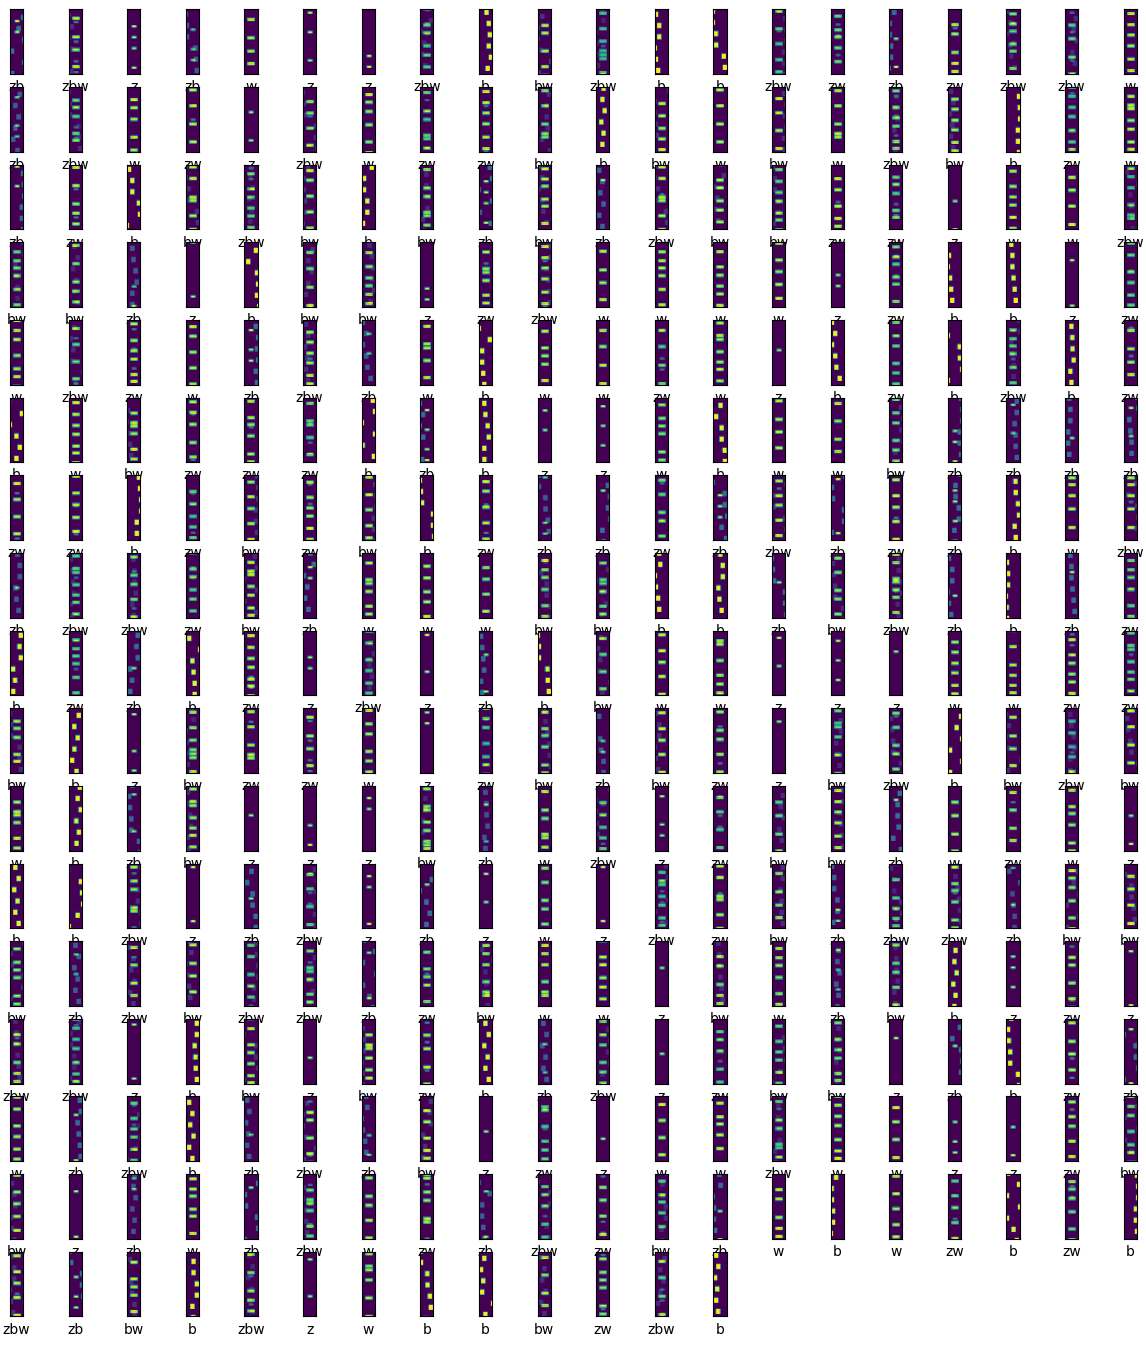

In [148]:
# Reload spectrum painting module in case the code changed
# and you want what is executed to be what you told the computer
# to do.
reload(sp_data)
reload(sp_plot)
reload(sp_predict)
reload(sp_training)

spectrograms = sp_data.load_spectrograms(data_dir="data/matlab",
                                         snr=30,
                                         # 20 MHz
                                         sample_rate=20000000)

train_test_sets = sp_training.create_spectrum_painting_train_test_sets(
    spectrograms=spectrograms,
    options=sp_training.SpectrumPaintingTrainingOptions(
        spectrogram_length=2500,
        downsample_resolution=64,
        k=3,
        l=16,
        d=4,
        color_depth=256
    )
)

print(f"Number of training images: {len(train_test_sets.y_train)}")
print(f"Number of testing images: {len(train_test_sets.y_test)}")
sp_plot.plot_train_images(train_test_sets.x_train_augmented, train_test_sets.y_train, train_test_sets.label_names)

(64, 13)
Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_67 (InputLayer)       [(None, 64, 13, 1)]          0         []                            
                                                                                                  
 input_68 (InputLayer)       [(None, 64, 13, 1)]          0         []                            
                                                                                                  
 conv2d_164 (Conv2D)         (None, 64, 13, 64)           3200      ['input_67[0][0]']            
                                                                                                  
 conv2d_167 (Conv2D)         (None, 64, 13, 64)           3200      ['input_68[0][0]']            
                                                                                  

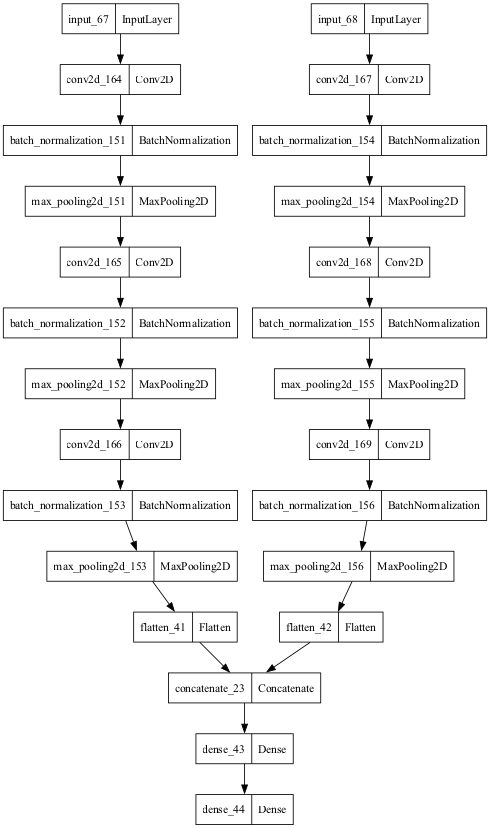

In [149]:
reload(sp_model)

image_shape = train_test_sets.x_train_augmented[0].shape
print(image_shape)

tf_model = sp_model.create_tensorflow_model(image_shape, len(train_test_sets.label_names))
tf_model.summary()
tf.keras.utils.plot_model(tf_model, to_file="output/model.png", dpi=60)


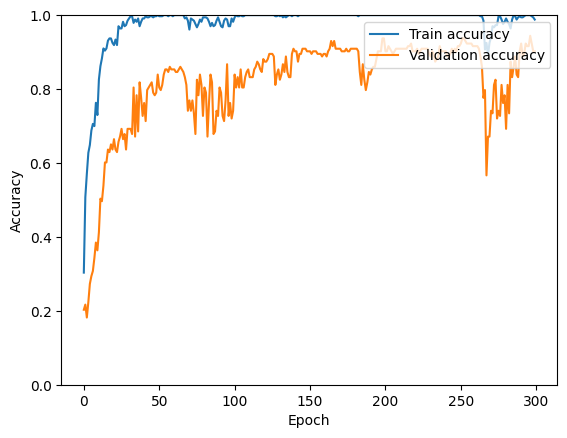

Final loss: 0.320630, final accuracy: 0.902098
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


In [150]:
reload(sp_model)
history = sp_model.fit_model(tf_model, train_test_sets, epochs=300)

sp_plot.plot_model_accuracy_epochs(history)

final_loss, final_acc = tf_model.evaluate([train_test_sets.x_test_augmented, train_test_sets.x_test_painted],
                                          train_test_sets.y_test,
                                          verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

output_file = "output/spectrum-painting-model.keras"

tf.saved_model.save(tf_model, "output/")
tf_model.save(output_file)


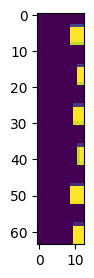

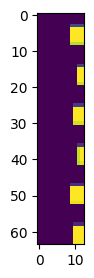

b


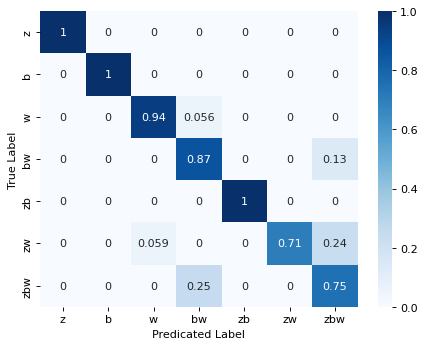

In [151]:
reload(sp_predict)
reload(sp_plot)

# Predict with full Tensorflow
test_img_augmented = train_test_sets.x_test_augmented[17]
test_img_painted = train_test_sets.x_test_painted[17]

plt.figure(figsize=(3, 3))
plt.imshow(test_img_augmented, cmap='viridis')
plt.show()

plt.figure(figsize=(3, 3))
plt.imshow(test_img_painted, cmap='viridis')
plt.show()

prediction = sp_predict.predict_full_model(tf_model, test_img_augmented, test_img_painted)

print(train_test_sets.label_names[prediction])

tf_model_y_predictions = [sp_predict.predict_full_model(tf_model, x_a, x_p) for (x_a, x_p) in
                          zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)]

sp_plot.plot_confusion_matrix(tf_model_y_predictions, train_test_sets.y_test, train_test_sets.label_names)

In [152]:
tflite_model = sp_model.convert_to_tensorflow_lite(tf_model,
                                                   train_test_sets.x_train_augmented,
                                                   train_test_sets.x_train_painted)
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

# Save the model.
with open('output/spectrum-painting-model.tflite', 'wb') as f:
    f.write(tflite_model)

# Create a hex dump of the model in a C file for the arduino.
# Use sed to make the variables const since they are huge.
! xxd -i output/spectrum-painting-model.tflite | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/model.h

INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmplqrtuyjj/assets


INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmplqrtuyjj/assets
/Users/sethd/Desktop/spectrum-painting/venv/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-05-27 14:32:58.505751: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-27 14:32:58.505763: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-27 14:32:58.505886: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmplqrtuyjj
2024-05-27 14:32:58.507863: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-27 14:32:58.507869: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/81/3wz7wxg90f3

Done. Model size = 180 KB


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


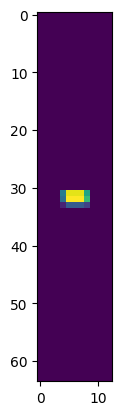

Prediction: z


In [153]:
reload(sp_predict)

# Test with Tensorflow Lite
test_img_augmented = train_test_sets.x_test_augmented[9]
test_img_painted = train_test_sets.x_test_painted[9]

plt.imshow(test_img_augmented, cmap="viridis")
plt.show()

prediction = sp_predict.predict_lite_model(tflite_model, test_img_augmented, test_img_painted)
print(f"Prediction: {train_test_sets.label_names[prediction]}")

Lite model accuracy = 0.8181818181818182


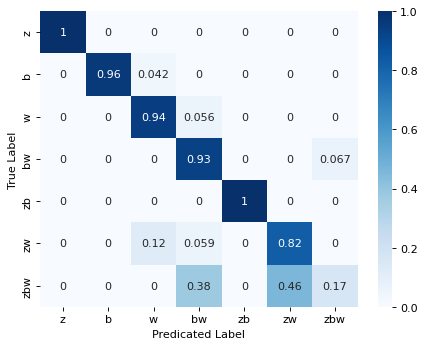

In [154]:
tflite_model_y_predictions: List[int] = []

for x_aug, x_painted in list(zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)):
    tflite_model_y_predictions.append(sp_predict.predict_lite_model(tflite_model, x_aug, x_painted))

tflite_accuracy = np.sum(train_test_sets.y_test == tflite_model_y_predictions) / len(train_test_sets.y_test)

print(f"Lite model accuracy = {tflite_accuracy}")
sp_plot.plot_confusion_matrix(np.asarray(tflite_model_y_predictions), train_test_sets.y_test,
                              train_test_sets.label_names)

(64, 13)
Label index 1
Label b


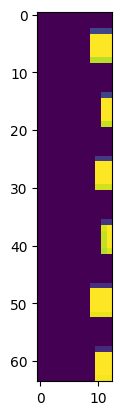

In [155]:
image_index = 17

test_img_augmented = train_test_sets.x_test_augmented[image_index]
test_img_painted = train_test_sets.x_test_painted[image_index]

print(test_img_augmented.shape)
print(f"Label index {train_test_sets.y_test[image_index]}")
print(f"Label {train_test_sets.label_names[train_test_sets.y_test[image_index]]}")

plt.imshow(test_img_augmented, cmap='viridis')
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))
test_img_augmented = test_img_augmented.astype(np.uint8)

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))
test_img_painted = test_img_painted.astype(np.uint8)

with open('output/augmented_image.bytes', 'wb') as f:
    f.write(test_img_augmented.flatten())

with open('output/painted_image.bytes', 'wb') as f:
    f.write(test_img_painted.flatten())

# Create a hex dump of the image in a C file for the arduino.
! xxd -i output/augmented_image.bytes | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/painted_image.h
! xxd -i output/painted_image.bytes | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/augmented_image.h

In [156]:
# compile and upload to Arduino
! arduino-cli compile --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino
! arduino-cli upload --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino --port /dev/cu.usbmodem1101

serial = Serial(port="/dev/cu.usbmodem1101", baudrate=9600, timeout=1000)

prediction = int(serial.readline().strip())
time = int(serial.readline().strip())
print(f"Full accuracy = {final_acc}")
print(f"Lite model size = {len(tflite_model) / 1000} KB, Lite accuracy = {tflite_accuracy}")
print(f"Prediction = {train_test_sets.label_names[prediction]}, Time = {time}ms")

Library Arduino_TensorFlowLite has been declared precompiled:
Precompiled library in "/Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite/src/cortex-m4/fpv4-sp-d16-softfp" not found
Precompiled library in "/Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite/src/cortex-m4" not found
Sketch uses 521480 bytes (53%) of program storage space. Maximum is 983040 bytes.
Global variables use 199568 bytes (76%) of dynamic memory, leaving 62576 bytes for local variables. Maximum is 262144 bytes.

Used library           Version     Path
Arduino_TensorFlowLite 2.4.0-ALPHA /Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite
Wire                               /Users/sethd/Library/Arduino15/packages/arduino/hardware/mbed/3.3.0/libraries/Wire

Used platform Version Path
arduino:mbed  3.3.0   /Users/sethd/Library/Arduino15/packages/arduino/hardware/mbed/3.3.0
Device       : nRF52840-QIAA
Version      : Arduino Bootloader (SAM-BA extended) 2.0 [Arduino:IKXYZ]
Address  